In [1]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attemptin

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import kornia.augmentation as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [3]:
BANDS = 100
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_BANDS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, num_bands=100):
        self.df = df
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.num_bands = num_bands
        self.transform = nn.Sequential(
            K.RandomHorizontalFlip(p=0.3),     
            K.RandomVerticalFlip(p=0.3),
            K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.5),
            K.RandomCrop((patch_size, patch_size), padding=4, p=0.5)
        )
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.base_path}/{row['id']}"

        try:
            img = np.load(img_path)

            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands]
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')

            img = img.astype(np.float32) / 65535.0  # Normalize image

            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to [C, H, W]

            if self.augment:
                img = self.transform(img.unsqueeze(0)).squeeze(0)

            if img.shape[1] != self.patch_size or img.shape[2] != self.patch_size:
                img = F.interpolate(img.unsqueeze(0), size=(self.patch_size, self.patch_size), mode='bilinear').squeeze(0)

            label = torch.tensor(row['label'], dtype=torch.long)  

            if label > 0:
                label = label - 1

            return img, label

        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            dummy_label = torch.tensor(0, dtype=torch.long)  
            return dummy_img, dummy_label



class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention


class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)


class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS, num_classes=100):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, num_classes) 
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


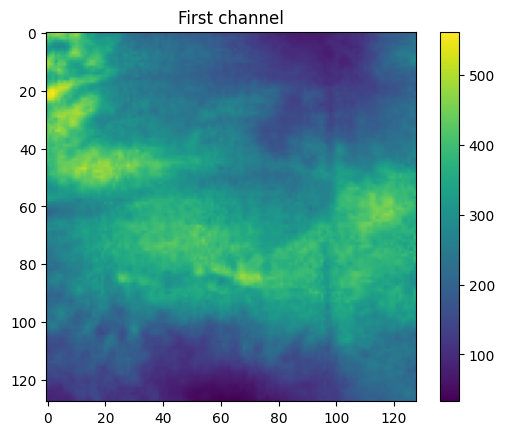

In [4]:
sample = np.load('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample1024.npy')  # (128, 128, 125)
plt.imshow(sample[:, :, 0])
plt.title('First channel')
plt.colorbar()
plt.show()

In [5]:
def evaluate_model(model, loader, criterion, device = DEVICE):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probabilities, dim=1)
            
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item() * inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(loader.dataset), np.array(all_preds), np.array(all_labels)


def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
                
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if torch.isnan(outputs).any():
                continue
                
            loss = criterion(outputs.squeeze(), labels) 
            
            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                valid_samples += inputs.size(0)
        
        if valid_samples > 0:
            train_loss /= valid_samples
            val_loss, val_preds, val_labels = evaluate_model(model, val_loader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            if len(val_preds.shape) == 2: 
                val_preds = np.argmax(val_preds, axis=1)
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            print(f"Sample predictions: {val_preds[:5]}, True labels: {val_labels[:5]}")
            
            
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), 'Spectrum_CNN.pth')
        else:
            print(f"Epoch {epoch+1}: No valid training samples")
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model


Epoch 1/50: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 1: Train Loss: 4.6107, Val Loss: 4.6124
Sample predictions: [18 18 18 18 18], True labels: [78 66 91 91 11]


Epoch 2/50: 100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 2: Train Loss: 4.5939, Val Loss: 4.6284
Sample predictions: [15 15 15 15 15], True labels: [78 66 91 91 11]


Epoch 3/50: 100%|██████████| 55/55 [01:05<00:00,  1.19s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 3: Train Loss: 4.5914, Val Loss: 4.6089
Sample predictions: [15 15 15 15 15], True labels: [78 66 91 91 11]


Epoch 4/50: 100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 4: Train Loss: 4.5791, Val Loss: 4.6132
Sample predictions: [15 15 15 15 15], True labels: [78 66 91 91 11]


Epoch 5/50: 100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 5: Train Loss: 4.5673, Val Loss: 4.6418
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 6/50: 100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 6: Train Loss: 4.5635, Val Loss: 4.6228
Sample predictions: [15 21 21 15 15], True labels: [78 66 91 91 11]


Epoch 7/50: 100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 7: Train Loss: 4.5575, Val Loss: 4.6600
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 8/50: 100%|██████████| 55/55 [01:12<00:00,  1.32s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 8: Train Loss: 4.5539, Val Loss: 4.6508
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 9/50: 100%|██████████| 55/55 [01:10<00:00,  1.29s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 9: Train Loss: 4.5554, Val Loss: 4.6498
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 10/50: 100%|██████████| 55/55 [01:09<00:00,  1.26s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 10: Train Loss: 4.5482, Val Loss: 4.6537
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 11/50: 100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 11: Train Loss: 4.5455, Val Loss: 4.6424
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 12/50: 100%|██████████| 55/55 [01:05<00:00,  1.19s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 12: Train Loss: 4.5452, Val Loss: 4.6583
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 13/50: 100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 13: Train Loss: 4.5400, Val Loss: 4.6617
Sample predictions: [82  4  4 82 82], True labels: [78 66 91 91 11]


Epoch 14/50: 100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 14: Train Loss: 4.5369, Val Loss: 4.6347
Sample predictions: [82 82 82 65 82], True labels: [78 66 91 91 11]


Epoch 15/50: 100%|██████████| 55/55 [01:09<00:00,  1.27s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 15: Train Loss: 4.5337, Val Loss: 4.6801
Sample predictions: [4 4 4 4 4], True labels: [78 66 91 91 11]


Epoch 16/50: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 16: Train Loss: 4.5292, Val Loss: 4.6775
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 17/50: 100%|██████████| 55/55 [01:06<00:00,  1.20s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 17: Train Loss: 4.5333, Val Loss: 4.6702
Sample predictions: [82 82 82 82 82], True labels: [78 66 91 91 11]


Epoch 18/50: 100%|██████████| 55/55 [01:05<00:00,  1.18s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 18: Train Loss: 4.5267, Val Loss: 4.6781
Sample predictions: [82 82  4 82 82], True labels: [78 66 91 91 11]


Epoch 19/50: 100%|██████████| 55/55 [01:06<00:00,  1.20s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 19: Train Loss: 4.5157, Val Loss: 4.7116
Sample predictions: [82 82  4 82 82], True labels: [78 66 91 91 11]


Epoch 20/50: 100%|██████████| 55/55 [01:05<00:00,  1.20s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 20: Train Loss: 4.5199, Val Loss: 4.6859
Sample predictions: [65 82 82 65 65], True labels: [78 66 91 91 11]


Epoch 21/50: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 21: Train Loss: 4.5146, Val Loss: 4.6624
Sample predictions: [65  4  4 65 65], True labels: [78 66 91 91 11]


Epoch 22/50: 100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 22: Train Loss: 4.5125, Val Loss: 4.6873
Sample predictions: [65  4  4 65 65], True labels: [78 66 91 91 11]


Epoch 23/50: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 23: Train Loss: 4.5030, Val Loss: 4.6826
Sample predictions: [11  4  4 11 11], True labels: [78 66 91 91 11]


Epoch 24/50: 100%|██████████| 55/55 [01:06<00:00,  1.22s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 24: Train Loss: 4.4967, Val Loss: 4.6806
Sample predictions: [65 11 22 65 65], True labels: [78 66 91 91 11]


Epoch 25/50: 100%|██████████| 55/55 [01:27<00:00,  1.59s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 25: Train Loss: 4.5062, Val Loss: 4.6978
Sample predictions: [65  4  4 65 65], True labels: [78 66 91 91 11]


Epoch 26/50: 100%|██████████| 55/55 [01:06<00:00,  1.20s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 26: Train Loss: 4.4952, Val Loss: 4.6941
Sample predictions: [65 82 21 65 65], True labels: [78 66 91 91 11]


Epoch 27/50: 100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 27: Train Loss: 4.4868, Val Loss: 4.6803
Sample predictions: [65 82 21 65 65], True labels: [78 66 91 91 11]


Epoch 28/50: 100%|██████████| 55/55 [01:11<00:00,  1.29s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 28: Train Loss: 4.4832, Val Loss: 4.7265
Sample predictions: [65  6  6 65 65], True labels: [78 66 91 91 11]


Epoch 29/50: 100%|██████████| 55/55 [01:07<00:00,  1.22s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 29: Train Loss: 4.4862, Val Loss: 4.7774
Sample predictions: [65 82 21 65 65], True labels: [78 66 91 91 11]


Epoch 30/50: 100%|██████████| 55/55 [01:07<00:00,  1.22s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 30: Train Loss: 4.4855, Val Loss: 4.7113
Sample predictions: [65 21  6 65 65], True labels: [78 66 91 91 11]


Epoch 31/50: 100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 31: Train Loss: 4.4758, Val Loss: 4.7140
Sample predictions: [65 82 21 65 65], True labels: [78 66 91 91 11]


Epoch 32/50: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 32: Train Loss: 4.4752, Val Loss: 4.7430
Sample predictions: [65 21 21 65 65], True labels: [78 66 91 91 11]


Epoch 33/50: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 33: Train Loss: 4.4684, Val Loss: 4.7700
Sample predictions: [65  6  6 65 65], True labels: [78 66 91 91 11]


Epoch 34/50: 100%|██████████| 55/55 [01:06<00:00,  1.22s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 34: Train Loss: 4.4484, Val Loss: 4.7303
Sample predictions: [65 21 21 65 65], True labels: [78 66 91 91 11]


Epoch 35/50: 100%|██████████| 55/55 [01:07<00:00,  1.23s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 35: Train Loss: 4.4586, Val Loss: 4.7595
Sample predictions: [65 21 21 65 65], True labels: [78 66 91 91 11]


Epoch 36/50: 100%|██████████| 55/55 [01:16<00:00,  1.38s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 36: Train Loss: 4.4627, Val Loss: 4.8091
Sample predictions: [65 62 21 60 65], True labels: [78 66 91 91 11]


Epoch 37/50: 100%|██████████| 55/55 [01:14<00:00,  1.36s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 37: Train Loss: 4.4625, Val Loss: 4.7479
Sample predictions: [65 21 21 65 65], True labels: [78 66 91 91 11]


Epoch 38/50: 100%|██████████| 55/55 [01:13<00:00,  1.33s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 38: Train Loss: 4.4588, Val Loss: 4.7664
Sample predictions: [12 18  6 12 12], True labels: [78 66 91 91 11]


Epoch 39/50: 100%|██████████| 55/55 [01:12<00:00,  1.31s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 39: Train Loss: 4.4545, Val Loss: 4.7633
Sample predictions: [65  6  6 65 99], True labels: [78 66 91 91 11]


Epoch 40/50: 100%|██████████| 55/55 [01:08<00:00,  1.25s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 40: Train Loss: 4.4426, Val Loss: 4.7531
Sample predictions: [65 21 21 60 65], True labels: [78 66 91 91 11]


Epoch 41/50: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 41: Train Loss: 4.4328, Val Loss: 4.7679
Sample predictions: [65  6  6 65 65], True labels: [78 66 91 91 11]


Epoch 42/50: 100%|██████████| 55/55 [01:07<00:00,  1.22s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 42: Train Loss: 4.4368, Val Loss: 4.8008
Sample predictions: [65 18  6 65 65], True labels: [78 66 91 91 11]


Epoch 43/50: 100%|██████████| 55/55 [01:05<00:00,  1.19s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 43: Train Loss: 4.4396, Val Loss: 4.7317
Sample predictions: [60 21 21 60 60], True labels: [78 66 91 91 11]


Epoch 44/50: 100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 44: Train Loss: 4.4328, Val Loss: 4.7719
Sample predictions: [65 18  6 65 65], True labels: [78 66 91 91 11]


Epoch 45/50: 100%|██████████| 55/55 [01:06<00:00,  1.22s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 45: Train Loss: 4.4277, Val Loss: 4.7647
Sample predictions: [65 18 18 65 65], True labels: [78 66 91 91 11]


Epoch 46/50: 100%|██████████| 55/55 [01:02<00:00,  1.14s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 46: Train Loss: 4.4326, Val Loss: 4.7863
Sample predictions: [65  6  6 65 65], True labels: [78 66 91 91 11]


Epoch 47/50: 100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 47: Train Loss: 4.4268, Val Loss: 4.7807
Sample predictions: [60 18  6 60 65], True labels: [78 66 91 91 11]


Epoch 48/50: 100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 48: Train Loss: 4.4259, Val Loss: 4.7767
Sample predictions: [65 18  6 60 65], True labels: [78 66 91 91 11]


Epoch 49/50: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 49: Train Loss: 4.4143, Val Loss: 4.8426
Sample predictions: [62  6  6 60 62], True labels: [78 66 91 91 11]


Epoch 50/50: 100%|██████████| 55/55 [01:11<00:00,  1.30s/it]


Error loading /kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot/sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Epoch 50: Train Loss: 4.4213, Val Loss: 4.8320
Sample predictions: [99  6  6 65 99], True labels: [78 66 91 91 11]


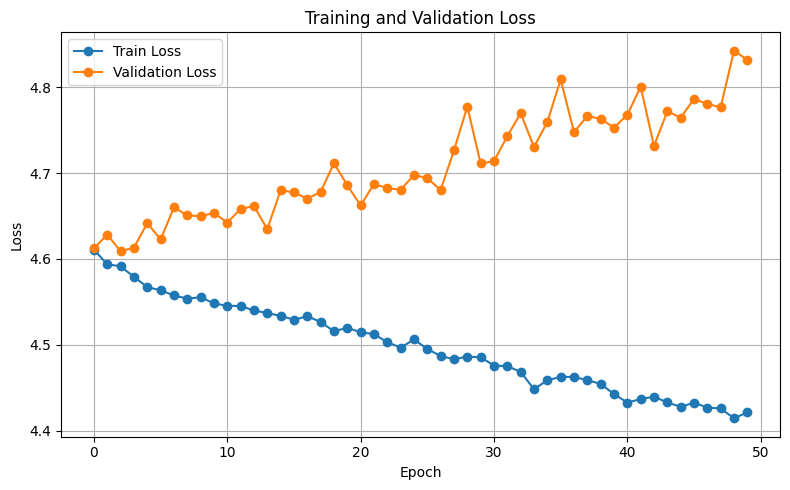

/tmp/ipykernel_13/2502131370.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Spectrum_CNN.pth'))


In [6]:
def main():
    train_df = pd.read_csv('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/train.csv')
    base_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot'
    
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
    
    train_dataset = HyperspectralDataset(train_df, base_path, augment=True)
    val_dataset = HyperspectralDataset(val_df, base_path, augment=False)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    model = HyperspectralCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    model = train_model(model, train_loader, val_loader, EPOCHS, criterion, optimizer)
    
    model.load_state_dict(torch.load('Spectrum_CNN.pth'))
    
    return model

if __name__ == '__main__':
    model = main()

In [7]:
model = HyperspectralCNN(in_channels=100).to(DEVICE)
model.load_state_dict(torch.load('Spectrum_CNN.pth'))
model.eval()
print("Model weights:", list(model.parameters())[0][0, 0, :5])
test_input = torch.randn(1, 100, 64, 64).to(DEVICE)

class TestHyperspectralDataset(Dataset):
    def __init__(self, test_csv, base_path, patch_size=64, num_bands=100):
        self.df = pd.read_csv(test_csv)
        self.base_path = base_path
        self.patch_size = patch_size
        self.num_bands = num_bands
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['id'])
        
        try:
            img = np.load(img_path)
            
            if len(img.shape) == 2:
                img = np.repeat(img[:, :, np.newaxis], self.num_bands, axis=2)
            elif len(img.shape) == 3:
                if img.shape[2] > self.num_bands:
                    img = img[:, :, :self.num_bands] 
                elif img.shape[2] < self.num_bands:
                    pad_width = ((0, 0), (0, 0), (0, self.num_bands - img.shape[2]))
                    img = np.pad(img, pad_width, mode='constant')
            
            normalized_img = np.zeros_like(img)
            for band in range(img.shape[2]):
                band_data = img[:, :, band]
                if np.max(band_data) > 0:  
                    normalized_img[:, :, band] = (band_data - np.min(band_data)) / (np.max(band_data) - np.min(band_data))
            
            img_tensor = torch.tensor(normalized_img, dtype=torch.float32).permute(2, 0, 1)
            
            if img_tensor.shape[1] != self.patch_size or img_tensor.shape[2] != self.patch_size:
                img_tensor = F.interpolate(img_tensor.unsqueeze(0), 
                                         size=(self.patch_size, self.patch_size),
                                         mode='bilinear').squeeze(0)
            
            return img_tensor, row['id']
        
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            dummy_img = torch.zeros(self.num_bands, self.patch_size, self.patch_size)
            return dummy_img, row['id']


test_csv_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/test.csv'
base_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot'

test_dataset = TestHyperspectralDataset(test_csv_path, base_path, num_bands=100)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

predictions = []
ids = []

with torch.no_grad():
    for inputs, img_ids in test_loader:
        inputs = inputs.to(DEVICE)
        
        if torch.isnan(inputs).any():
            print(f"Skipping batch with NaN values")
            predictions.extend([50] * len(img_ids))  
            ids.extend(img_ids)
            continue
            
        outputs = model(inputs)
        preds = outputs.squeeze().cpu().numpy()
        print(preds)
        preds = np.clip(preds, 1, 100).round().astype(int)
        print(preds)
        if isinstance(preds, np.ndarray) and preds.ndim > 1:
            preds = np.max(preds, axis=1)  

        if len(preds) != len(img_ids):
            preds = preds[:len(img_ids)]  

        predictions.extend(preds.tolist())  
        ids.extend(img_ids)



submission_df = pd.DataFrame({'ID': ids, 'TARGET': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission created successfully")
print("\nSubmission preview:")
print(submission_df.head())

Model weights: tensor([[ 0.0258,  0.0135, -0.0184],
        [ 0.0159,  0.0020, -0.0334],
        [-0.0155,  0.0136,  0.0113]], grad_fn=<SliceBackward0>)


/tmp/ipykernel_13/4053426474.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Spectrum_CNN.pth'))


[[ 0.03869649  0.08446439 -0.0102202  ...  0.25569844 -0.08244653
   0.16647996]
 [ 0.0375048   0.08331688 -0.01001849 ...  0.25429457 -0.08043471
   0.16577892]
 [ 0.0366631   0.08320734 -0.01133287 ...  0.2520104  -0.08001389
   0.16450123]
 ...
 [ 0.03910296  0.0846407  -0.00987826 ...  0.25700235 -0.08320782
   0.16686204]
 [ 0.03973525  0.08454682 -0.00836484 ...  0.2588343  -0.08284917
   0.1681545 ]
 [ 0.03925423  0.08459082 -0.00965141 ...  0.25787008 -0.08353693
   0.16709651]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[ 0.03963105  0.08419405 -0.00817414 ...  0.25842696 -0.08225895
   0.16824593]
 [ 0.03944343  0.08434072 -0.00857709 ...  0.2589426  -0.08294795
   0.16779424]
 [ 0.03846453  0.08415709 -0.01012509 ...  0.25634322 -0.0825928
   0.16630961]
 ...
 [ 0.03883203  0.08400334 -0.00899334 ...  0.25698823 -0.08180501
   0.16722228]
 [ 0.04197558  0.08530982 -0.00632614 ...  0.26334503 -0.084